In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC

from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support


RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE)

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14

# To plot pretty figures
%matplotlib inline

# Credit Card Dataset

In [61]:
data_train = pd.read_csv("data/credit_train_reduced.csv", index_col=None)
data_test = pd.read_csv("data/credit_test_reduced.csv", index_col=None)

X_train = data_train.drop(data_train.columns[-1],axis=1)
y_train = data_train.iloc[:,-1]

X_test = data_test.drop(data_test.columns[-1],axis=1)
y_test = data_test.iloc[:,-1]
data_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.114107,0.188459,0.149144,1.153868,0.224011,0.396246,0.020168,0.217603,-0.141379,0.090719,...,0.065655,0.367010,-0.090954,-0.271464,0.646597,-0.217493,0.035881,-0.004553,1.00,0
1,1.910941,0.686774,-0.595770,3.817385,0.288991,-0.660187,0.365387,-0.261102,-1.226056,1.527476,...,0.266636,0.805442,0.114189,0.401013,0.069967,0.108304,-0.039724,-0.047338,5.14,0
2,0.013514,0.452287,-0.738086,-0.950309,1.405159,-0.423082,1.115085,-0.073982,-0.349808,-0.362877,...,0.152423,0.411430,-0.017938,0.227643,-0.857711,0.444818,0.136231,0.229043,22.95,0
3,-1.273388,0.270815,1.256719,1.064659,-1.401545,0.234430,1.194255,0.412955,-0.528987,-1.038559,...,0.407454,0.673393,0.759378,0.580046,-0.310258,-0.463227,-0.023899,0.134970,325.00,0
4,1.978615,0.114560,-1.322450,0.577586,0.348417,-0.376863,-0.211046,-0.123861,1.623757,-0.637724,...,-0.138925,-0.031185,0.191191,0.598530,-0.182579,0.389251,-0.075180,-0.040764,14.05,0


In [62]:
inlier_train = X_train[y_train==0]
inlier_test = X_test[y_test==0]
outliers = X_test[y_test==1]
outliers_all = np.concatenate((outliers, X_train[y_train==1]))

## Training each model

In [63]:
%%time
svclassifier = SVC(kernel="rbf", degree=5)
svclassifier.fit(X_train, y_train)

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 9.22 s, sys: 167 ms, total: 9.38 s
Wall time: 8.84 s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [64]:
SVM_scores = svclassifier.decision_function(X_test)
SVM_prec, SVM_recall, _ = precision_recall_curve(y_test, SVM_scores)
SVM_average_precision = average_precision_score(y_test, SVM_scores)

In [73]:
%%time 
IF_model = IsolationForest(n_estimators=130,max_features=0.63,max_samples=256,
                           random_state=42,n_jobs=-1,contamination=0.01802679, behaviour='new')

IF_model.fit(X_train,y_train)

CPU times: user 1.88 s, sys: 163 ms, total: 2.04 s
Wall time: 1.12 s


IsolationForest(behaviour='new', bootstrap=False, contamination=0.01802679,
                max_features=0.63, max_samples=256, n_estimators=130, n_jobs=-1,
                random_state=42, verbose=0, warm_start=False)

In [74]:
IF_score=IF_model.decision_function(X_test)
IF_prec, IF_recall, _ = precision_recall_curve(y_test, -IF_score)
IF_average_precision = average_precision_score(y_test, -IF_score)

In [67]:
%%time
best_gmm = GaussianMixture(n_components=19, covariance_type="full", max_iter=100, n_init=5)
best_gmm.fit(inlier_train)

CPU times: user 2min 9s, sys: 883 ms, total: 2min 10s
Wall time: 32.7 s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=19, n_init=5,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [68]:
test_scores = pd.DataFrame(best_gmm.score_samples(inlier_test))
outlier_scores_all = pd.DataFrame(best_gmm.score_samples(outliers_all))
GMM_probs = np.concatenate((test_scores, outlier_scores_all))
GMM_true = np.concatenate(([0]*len(test_scores), [1]*len(outlier_scores_all)))
GMM_prec, GMM_recall, _ = precision_recall_curve(GMM_true, -GMM_probs)
GMM_average_precision = average_precision_score(GMM_true, -GMM_probs)

## Plotting final figure

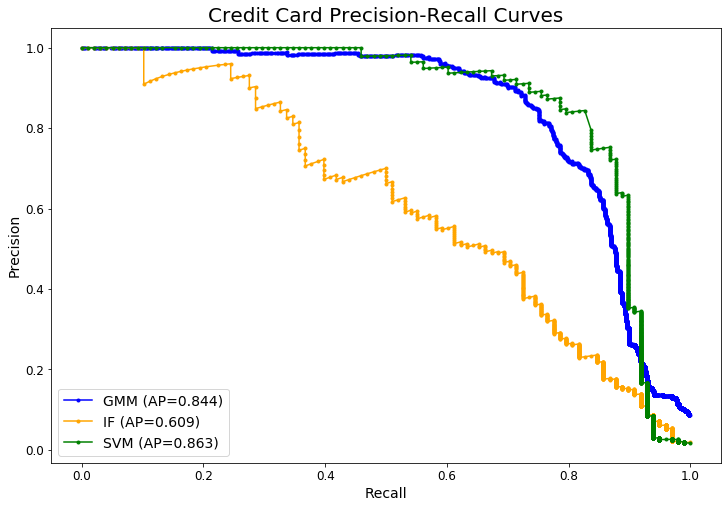

In [75]:
plt.figure(figsize=(12, 8))
plt.plot(GMM_recall, GMM_prec, marker='.', color="blue",
         label='GMM (AP={0:0.3f})'.format(GMM_average_precision))
plt.plot(IF_recall, IF_prec, marker='.', color="orange",
         label='IF (AP={0:0.3f})'.format(IF_average_precision))
plt.plot(SVM_recall, SVM_prec, marker='.', color="green",
         label='SVM (AP={0:0.3f})'.format(SVM_average_precision))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Credit Card Precision-Recall Curves')

plt.legend()
plt.savefig("credit.png", dpi=600)

# Cardio Dataset

In [51]:
data_train = pd.read_csv("data/cardio_train.csv", index_col=None)
data_test = pd.read_csv("data/cardio_test.csv", index_col=None)

X_train = data_train.drop(data_train.columns[-1],axis=1)
y_train = data_train.iloc[:,-1]

X_test = data_test.drop(data_test.columns[-1],axis=1)
y_test = data_test.iloc[:,-1]
data_train.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-2.746331,0.674374,-0.203640,0.569296,-0.683598,-0.061401,-0.278295,1.161352,-0.862298,-0.420487,...,0.342006,-0.565334,-0.409388,-0.488279,-1.441887,-1.083848,-1.561651,-0.222985,-2.126605,0
1,-1.476526,-0.487369,-0.203640,0.159199,-0.127511,-0.061401,-0.278295,-1.171841,-0.051613,0.948799,...,-0.655829,-0.235325,-0.753395,2.414444,-0.600269,-0.828456,-0.940945,-0.323186,-0.493294,0
2,-0.312539,-0.380829,0.066072,-1.635871,-0.683598,-0.061401,-0.278295,0.144320,-0.630673,-0.420487,...,-1.368567,-0.455331,0.622631,-0.488279,-0.179460,0.001569,-0.182306,-0.556988,1.140018,0
3,-0.947441,3.464968,-0.203640,-0.961999,-0.683598,-0.061401,-0.278295,-1.231666,0.874885,-0.420487,...,0.342006,-0.675337,-1.097401,-0.488279,0.000886,0.001569,-0.113338,-0.523588,-0.493294,0
4,0.533997,-0.437880,-0.163445,0.697949,1.175504,-0.061401,-0.278295,0.802400,0.411636,-0.420487,...,-1.083472,0.094683,0.622631,-0.488279,0.181233,0.001569,0.300465,0.044218,1.140018,0


In [52]:
inlier_train = X_train[y_train==0]
inlier_test = X_test[y_test==0]
outliers = X_test[y_test==1]
outliers_all = np.concatenate((outliers, X_train[y_train==1]))

## Training each model

In [53]:
%%time
svclassifier = SVC(kernel="rbf", degree=5)
svclassifier.fit(X_train, y_train)

CPU times: user 15.5 ms, sys: 1.85 ms, total: 17.4 ms
Wall time: 15.6 ms


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [54]:
SVM_scores = svclassifier.decision_function(X_test)
SVM_prec, SVM_recall, _ = precision_recall_curve(y_test, SVM_scores)
SVM_average_precision = average_precision_score(y_test, SVM_scores)

In [55]:
%%time 
IF_model = IsolationForest(n_estimators=14,max_features=1.0,max_samples=75,
                           random_state=40,contamination=0.099, behaviour='new')
IF_model.fit(X_train,y_train)

CPU times: user 37.1 ms, sys: 3.1 ms, total: 40.2 ms
Wall time: 39.2 ms


IsolationForest(behaviour='new', bootstrap=False, contamination=0.099,
                max_features=1.0, max_samples=75, n_estimators=14, n_jobs=None,
                random_state=40, verbose=0, warm_start=False)

In [56]:
IF_score=IF_model.decision_function(X_test)
IF_prec, IF_recall, _ = precision_recall_curve(y_test, -IF_score)
IF_average_precision = average_precision_score(y_test, -IF_score)

In [57]:
%%time
best_gmm = GaussianMixture(n_components=10, covariance_type="full", max_iter=100, n_init=5)
best_gmm.fit(inlier_train)

CPU times: user 4.11 s, sys: 52.6 ms, total: 4.16 s
Wall time: 1.06 s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=5,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [58]:
test_scores = pd.DataFrame(best_gmm.score_samples(inlier_test))
outlier_scores_all = pd.DataFrame(best_gmm.score_samples(outliers_all))
GMM_probs = np.concatenate((test_scores, outlier_scores_all))
GMM_true = np.concatenate(([0]*len(test_scores), [1]*len(outlier_scores_all)))
GMM_prec, GMM_recall, _ = precision_recall_curve(GMM_true, -GMM_probs)
GMM_average_precision = average_precision_score(GMM_true, -GMM_probs)

## Plotting final figure

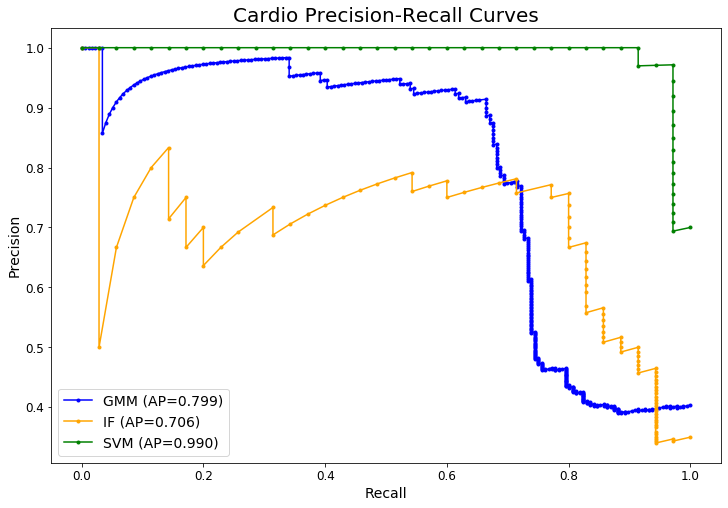

In [59]:
plt.figure(figsize=(12, 8))
plt.plot(GMM_recall, GMM_prec, marker='.', color="blue",
         label='GMM (AP={0:0.3f})'.format(GMM_average_precision))
plt.plot(IF_recall, IF_prec, marker='.', color="orange",
         label='IF (AP={0:0.3f})'.format(IF_average_precision))
plt.plot(SVM_recall, SVM_prec, marker='.', color="green",
         label='SVM (AP={0:0.3f})'.format(SVM_average_precision))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Cardio Precision-Recall Curves')

plt.legend()
plt.savefig("cardio.png", dpi=600)